##🚀drive mounting

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1gnEmwyGy0LbTbJbAObG1GluWXj6wpHMD/[2024-2025] AN2DL/Homework 2


##📚importing libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries

import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


##📊Dataset

In previous explorations of the dataset we found some outliers and we decided to definitively remove them from out dataset

In [ ]:
import numpy as np

data = np.load("filtered_mars_for_students.npz")
training_set = data["training_set"]

X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
import gc
del data, training_set
gc.collect()

28454

###visual inspection

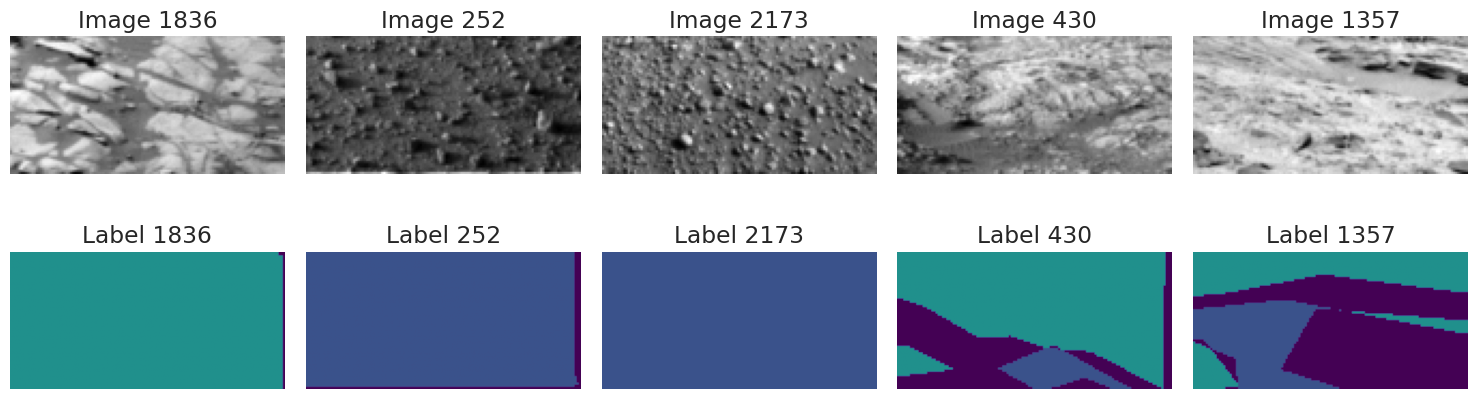

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot random images with labels
def plot_random_images_with_labels(images, labels, num=5):
    """
    Plot `num` random images with their corresponding label masks.

    Parameters:
        images (numpy.ndarray): Array of images.
        labels (numpy.ndarray): Array of label masks.
        num (int): Number of images to plot.
    """
    # Select `num` random indices
    random_indices = np.random.choice(len(images), num, replace=False)

    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(random_indices):
        # Display the image
        plt.subplot(2, num, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"Image {idx}")
        plt.axis("off")

        # Display the mask with viridis
        plt.subplot(2, num, i + 1 + num)
        plt.imshow(labels[idx], cmap='viridis', vmin=0, vmax=4)
        plt.title(f"Label {idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Plot 5 random images with labels
plot_random_images_with_labels(X_train, y_train, num=5)


###data processing

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

Distribuzione delle classi: {0.0: 4988826, 1.0: 6957538, 2.0: 4776810, 3.0: 3770823, 4.0: 26963}


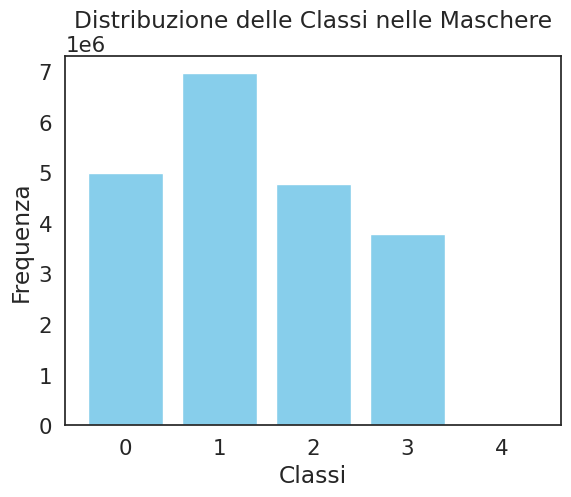

Numero di classi uniche nel dataset: 5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute class frequencies
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Visualization
print("Distribuzione delle classi:", class_distribution)

# Bar chart
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Classi')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle Classi nelle Maschere')
plt.xticks(list(class_distribution.keys()))
plt.show()

# Number of unique classes
print(f"Numero di classi uniche nel dataset: {len(class_distribution)}")


In [ ]:
from sklearn.model_selection import train_test_split

# First split: division between train and temp (which will become validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Second split: division between validation and test
X_val, X_test_tmp, y_val, y_test_tmp = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the size of the new splits
print(f"Number of images:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test_tmp)}")


Number of images:
Train: 2004
Validation: 250
Test: 251


Distribuzione delle classi: {0.0: 3979893, 1.0: 5532162, 2.0: 3924593, 3.0: 2958791, 4.0: 21329}


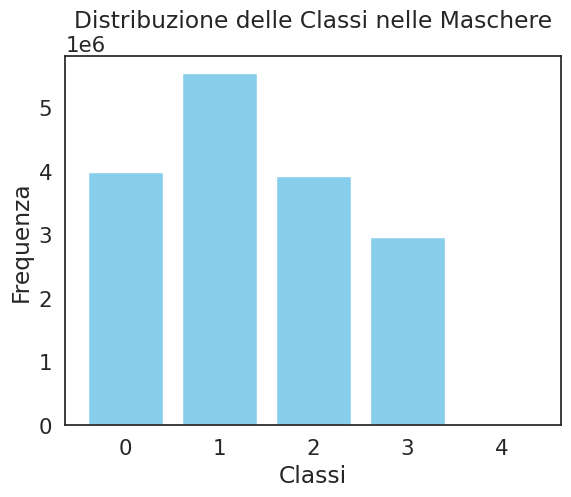

Numero di classi uniche nel dataset: 5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute class frequencies
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Visualization
print("Distribuzione delle classi:", class_distribution)

# Bar chart
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Class Distribution in Masks')
plt.xticks(list(class_distribution.keys()))
plt.show()

# Number of unique classes
print(f"Numero di classi uniche nel dataset: {len(class_distribution)}")

It is clear that there are classes that are highly represented, while others are significantly less represented

###preparing the dataset

We prepare the training dataset (applying geometric augmentation such as random flipping), the validation dataset, and the test dataset. Additionally, we set essential parameters such as batch size, patience, number of epochs, and learning rate

In [ ]:
@tf.function
def random_flip(image, label, seed=None):
    """
    Random horizontal flip for image and its corresponding segmentation mask (label).
    Displays three images with masks before and after the flip.

    Args:
        image: Tensor representing the image, size [H, W, C].
        label: Tensor representing the segmented mask, size [H, W] or [H, W, 1].
        seed: Optional seed for the random generator.

    Returns:
        Flipped (or unchanged) image and label.
    """
    # Generate a random seed if not provided
    if seed is None:
        seed = np.random.randint(0, 1000000)

    # Ensure the label has 3 dimensions
    if len(label.shape) == 2:  # Add a channel dimension
        label = tf.expand_dims(label, axis=-1)

    # Save copies of the original images and masks for visualization
    original_image = image.numpy() if tf.executing_eagerly() else image
    original_label = label.numpy() if tf.executing_eagerly() else label

    # Random uniform to determine the flip
    flip_prob = tf.random.uniform([], seed=seed)

    # Apply the conditional horizontal flip
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )

    return image, label


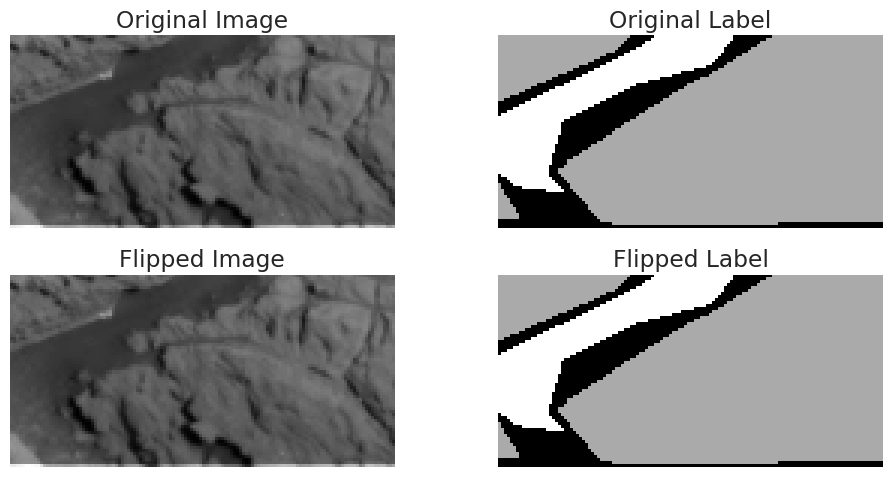

In [ ]:
# Take an instance from X_train and y_train
sample_image = X_train[30]  # First image from X_train
sample_label = y_train[30]  # First mask from y_train

# Convert to TensorFlow tensors (if necessary)
sample_image = tf.convert_to_tensor(sample_image, dtype=tf.float32)
sample_label = tf.convert_to_tensor(sample_label, dtype=tf.float32)

# Ensure both have at least 3 dimensions
if len(sample_image.shape) == 2:  # (H, W)
    sample_image = tf.expand_dims(sample_image, axis=-1)  # Add channel dimension

if len(sample_label.shape) == 2:  # (H, W)
    sample_label = tf.expand_dims(sample_label, axis=-1)  # Add channel dimension

# Apply the random_flip function on the instance
flipped_image, flipped_label = random_flip(sample_image, sample_label)

# Display the results
def plot_from_array(original_image, original_label, augmented_image, augmented_label):
    """
    Display an instance of X_train and y_train before and after augmentation.
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image.numpy().squeeze(), cmap='gray')  # Removes unnecessary dimensions
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.title("Original Label")
    plt.imshow(original_label.numpy().squeeze(), cmap='gray')  # Removes unnecessary dimensions
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.title("Flipped Image")
    plt.imshow(augmented_image.numpy().squeeze(), cmap='gray')  # Removes unnecessary dimensions
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.title("Flipped Label")
    plt.imshow(augmented_label.numpy().squeeze(), cmap='gray')  # Removes unnecessary dimensions
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display the instance and the flipped result
plot_from_array(sample_image, sample_label, flipped_image, flipped_label)


In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

In [ ]:
import numpy as np

# Add channel to X_train and X_test
X_train = np.expand_dims(X_train, axis=-1)  # Add a channel
X_test_tmp = np.expand_dims(X_test_tmp, axis=-1)  # Add a channel
X_val = np.expand_dims(X_val, axis=-1)

input_shape = X_train.shape[1:]  # The input shape (excluding batch dimension)
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")


Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
import tensorflow as tf

def make_dataset(X_train, y_train, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset from X_train and y_train.

    Parameters:
    - X_train: Training images.
    - y_train: Training labels.
    - batch_size: Number of elements per batch.
    - shuffle: If True, shuffle the dataset.
    - augment: If True, apply augmentations to the images.
    - seed: Seed for randomness (optional).

    Returns:
    - dataset: TensorFlow dataset.
    """

    # Add the fourth dimension to y_train if necessary
    if len(y_train.shape) == 3:  # If y_train is shaped (n_samples, height, width)
        y_train = tf.expand_dims(y_train, axis=-1)  # Convert to (n_samples, height, width, 1)

    # Create a dataset from X_train and y_train
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    # Apply shuffle
    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply augmentations
    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Perform batching
    dataset = dataset.batch(batch_size, drop_remainder=False)

    # Optimize data loading
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


In [ ]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    X_test_tmp, y_test_tmp,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'float64'>


Visualizing examples from the training set:


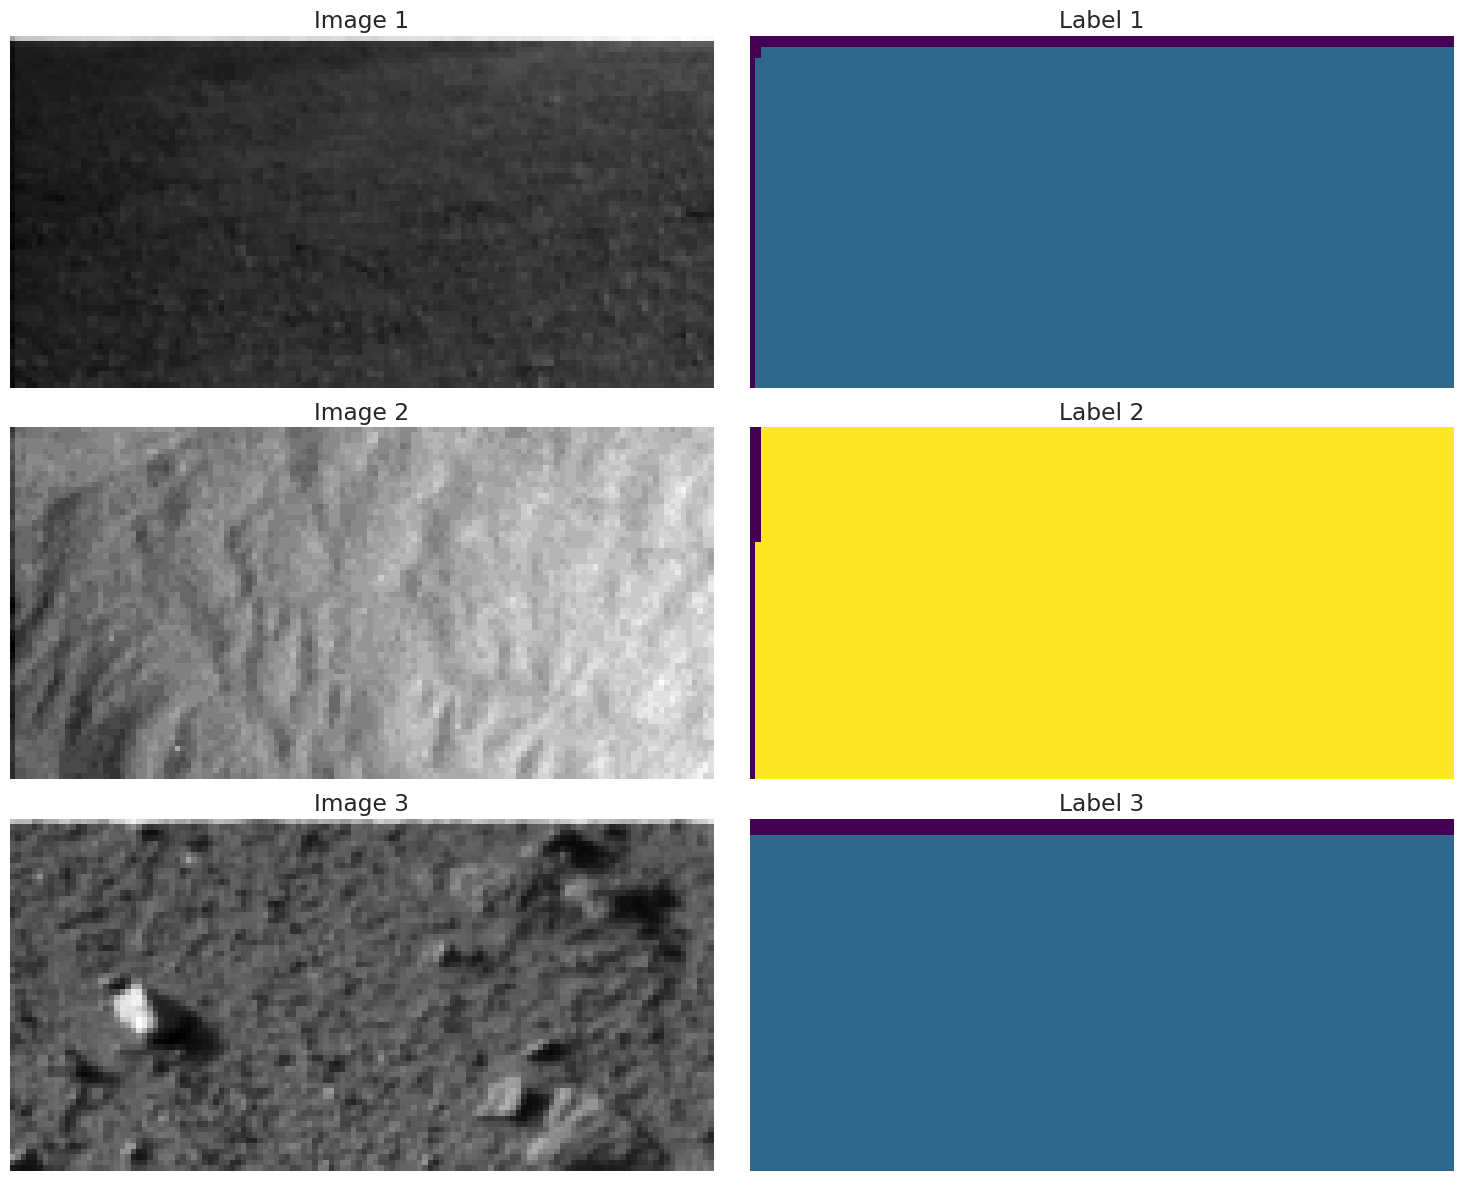

In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(tf.squeeze(images[j], axis=-1)*255, cmap='gray')
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=3)

Above are examples of the training dataset created

##💡Model

We define a basic U-Net model, consisting of 2 downsampling layers and 2 upsampling layers. For each layer (including the bottleneck), we use a basic U-Block layer

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [ ]:
def get_unet_model(input_shape=input_shape, num_classes=5, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_2        │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d_2[0]… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 473,669 (1.81 MB)

 Trainable params: 472,389 (1.80 MB)

 Non-trainable params: 1,280 (5.00 KB)

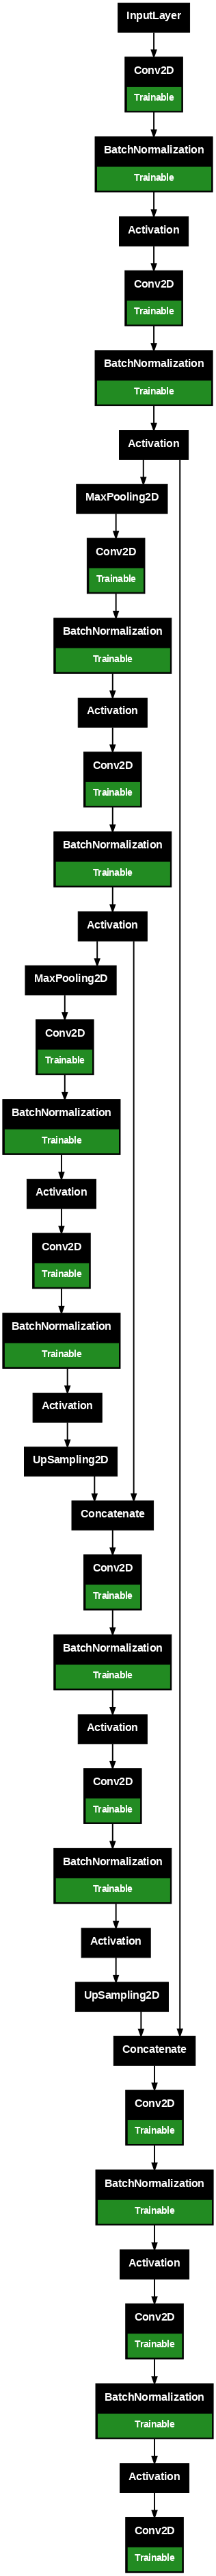

In [ ]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

Above, you can see the structure of the created model and the number of parameters

We define the MIoU (Mean Intersection over Union) and the Viz Callback to monitor the model's performance during training. MIoU is used as a metric to evaluate the accuracy of pixel-wise segmentation, while the Viz Callback helps visualize the model's predictions in real-time, providing insights into the training process.

In [ ]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image=self.X_val[0]
            label=self.y_val[0]
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = 5
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(X_val[0], y_val[0])

We compute class weights based on the frequency of each class in the training data to address class imbalance. These weights are then used in a custom loss function that applies different penalties to each class during training

In [ ]:
classes, counts=np.unique(y_train, return_counts=True)

total_pixels=y_train.size
frequencies=counts/total_pixels

class_weights=1.0/frequencies
class_weights/=np.sum(class_weights)

print('Classi:', classes)
print('Frequenze:', frequencies)
print('Pesi:', class_weights)

Classi: [0. 1. 2. 3. 4.]
Frequenze: [0.24242853 0.33698241 0.23906003 0.18022981 0.00129922]
Pesi: [0.00524455 0.00377298 0.00531845 0.00705449 0.97860952]


In [ ]:
def weighted_loss(class_weights):
  def loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    weights = tf.gather(class_weights, y_true) # Apply weights
    weights = tf.cast(weights, tf.float32)
    # Reshape weights to match the shape of the loss
    weights = tf.squeeze(weights, axis=-1) # Remove the channel dimension from weights

    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return tf.reduce_mean(weights * loss) # Now the shapes should match
  return loss

loss_fn = weighted_loss(class_weights)


In [ ]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=loss_fn,
    optimizer = tf.keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
    weight_decay=1e-4),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


###training

We can train the model, also using early stopping to prevent overfitting and reduce computational time

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.2177 - loss: 0.0104 - mean_iou: 0.0950 - val_accuracy: 0.2129 - val_loss: 0.0104 - val_mean_iou: 0.0717
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 119ms/step - accuracy: 0.2705 - loss: 0.0093 - mean_iou: 0.1369 - val_accuracy: 0.2129 - val_loss: 0.0112 - val_mean_iou: 0.0717
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.3297 - loss: 0.0085 - mean_iou: 0.1826 - val_accuracy: 0.2129 - val_loss: 0.0131 - val_mean_iou: 0.0717
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.3823 - loss: 0.0082 - mean_iou: 0.2207 - val_accuracy: 0.2129 - val_loss: 0.0167 - val_mean_iou: 0.0717
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.4163 - loss: 0.0079 - mean_iou: 0.2466 - val_accuracy: 0.2129 - val_loss: 0.0190 - val_mean_iou: 0.0717
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.4547 - loss: 0.0078 - mean_iou: 0.2681 - val_accuracy: 0.2129 - val_loss:

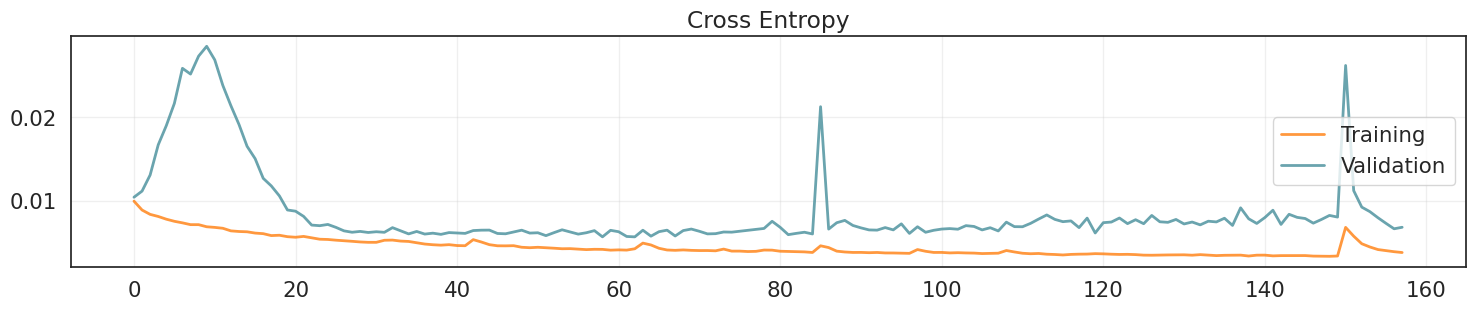

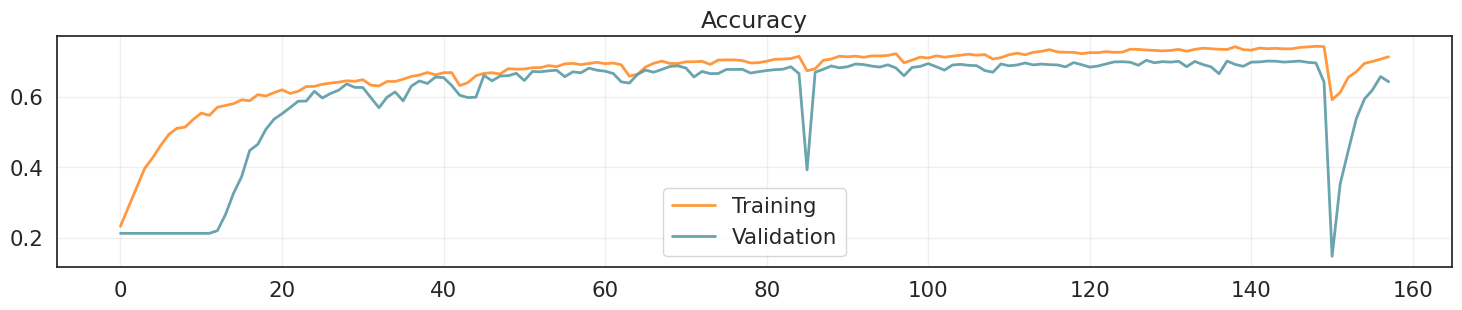

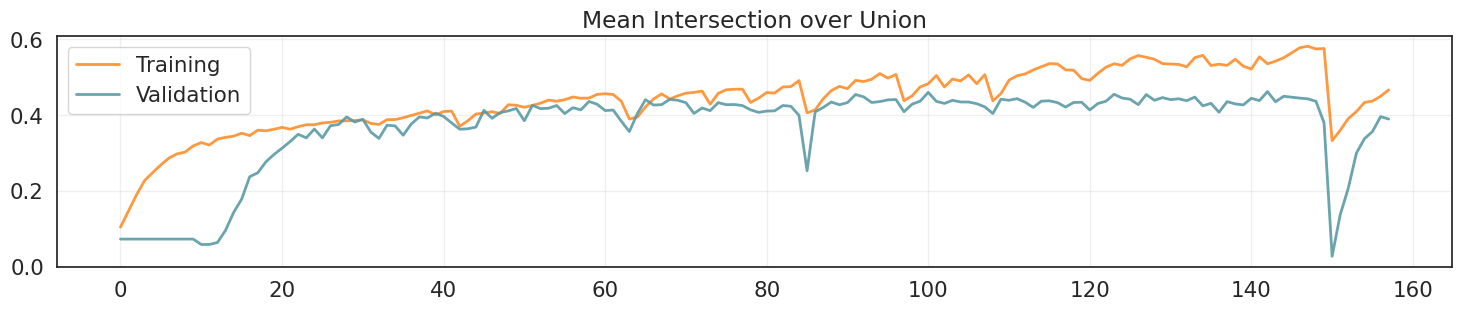

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Above, you can see the progress of the Loss function and of the accuracy and miou for both Training and Validation during the model training

###make inference

We can now use the trained model to see how it performs on a test dataset, never seen by the model before

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_2        │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d_2[0]… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 473,669 (1.81 MB)

 Trainable params: 472,389 (1.80 MB)

 Non-trainable params: 1,280 (5.00 KB)

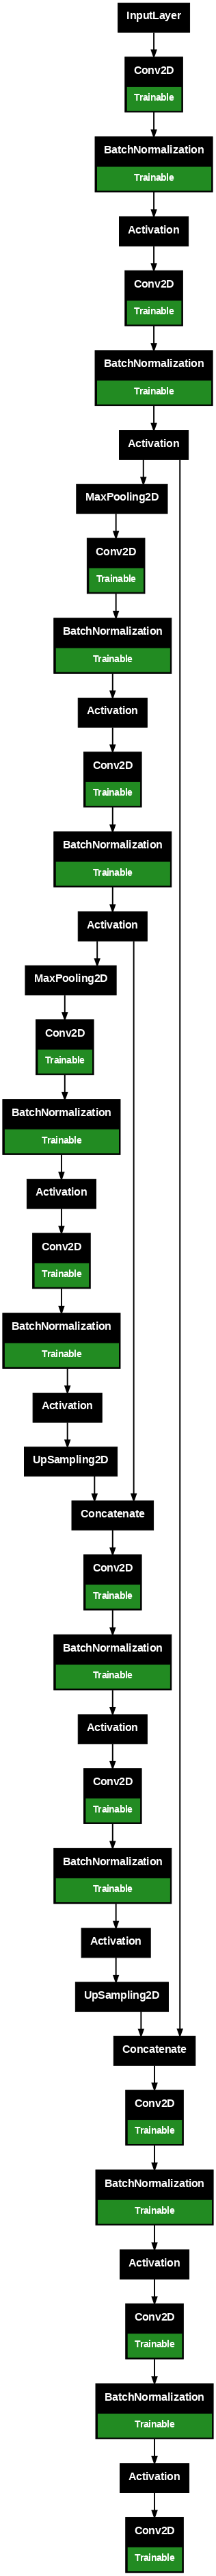

In [ ]:
# Load UNet model without compiling
model = tfk.models.load_model('UNet_46.21.keras', compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]
)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [ ]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

Test Accuracy: 0.7235
Test Mean Intersection over Union: 0.4383


Above, we can see the results from the predictions made on the test dataset

Below, we process the test dataset, generating predictions using the trained model. Random samples are visualized, displaying the original image, the true mask, and the predicted mask to evaluate the model's performance

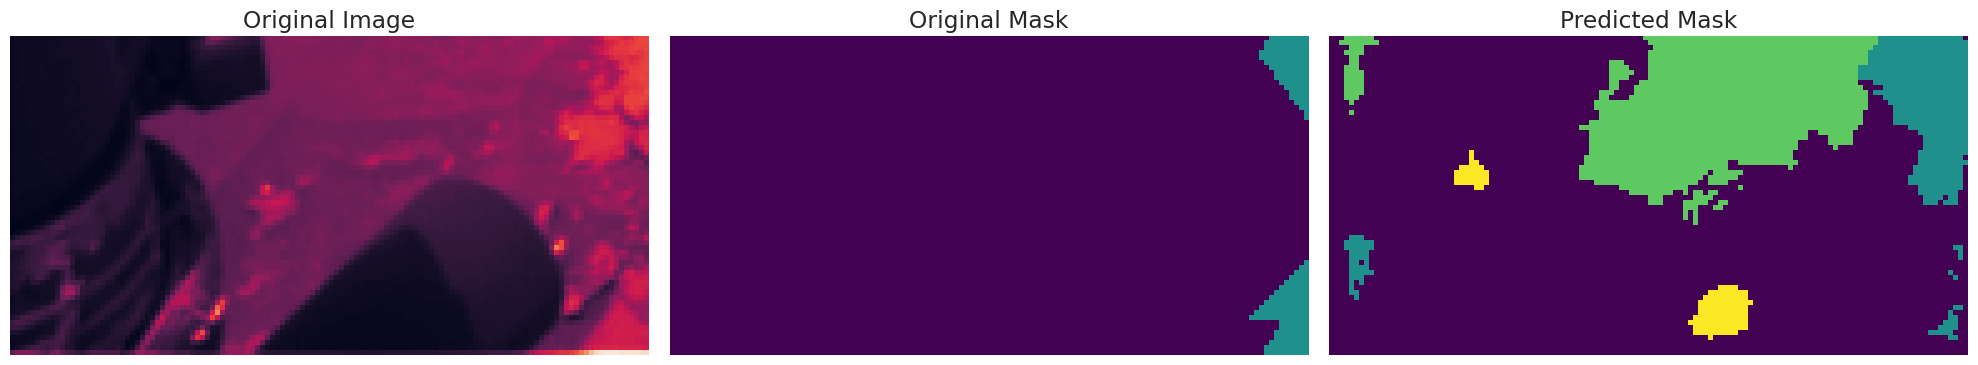

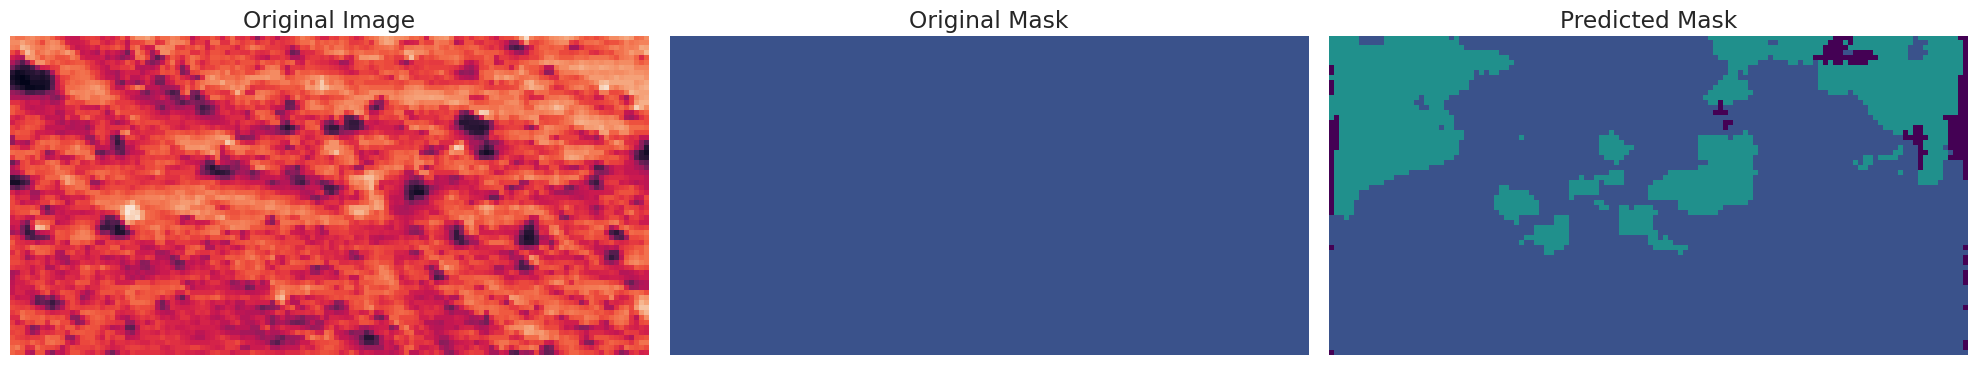

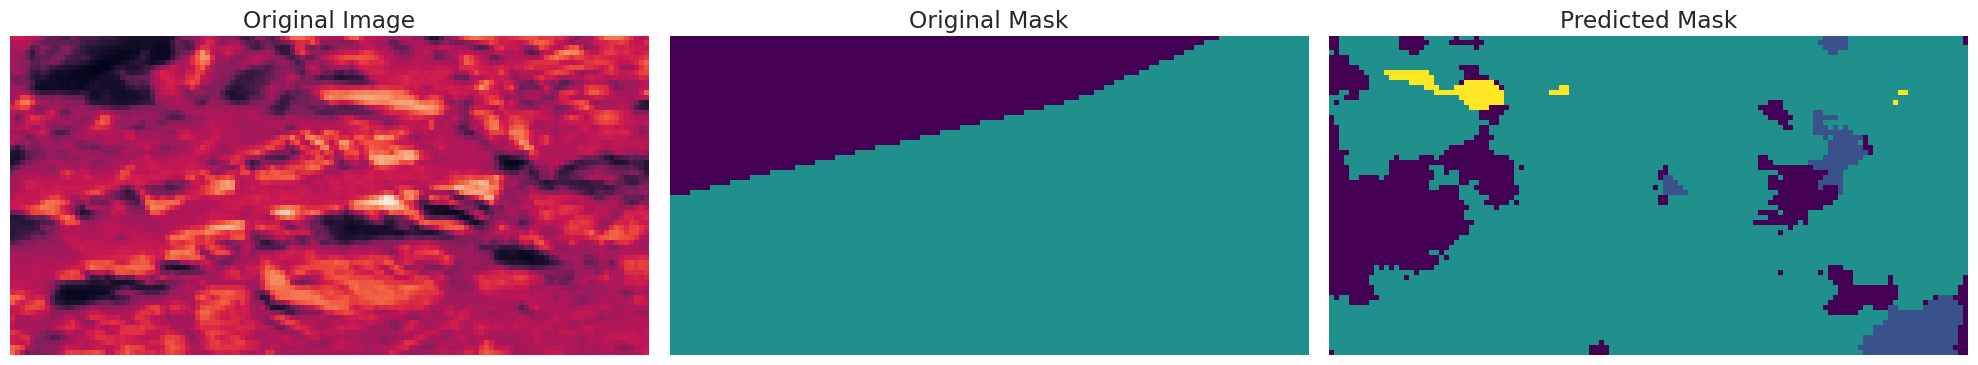

In [ ]:
def plot_triptychs(dataset, model, num_samples=1):
    """
    Plot triptychs (original image, true mask, predicted mask) for samples from a tf.data.Dataset

    Parameters:
    dataset: tf.data.Dataset - The dataset containing image-label pairs
    model: tf.keras.Model - The trained model to generate predictions
    num_samples: int - Number of samples to plot
    """
    # Take samples from the dataset
    samples = dataset.take(num_samples)

    for images, labels in samples:
        # If we have a batch, take the first example
        if len(images.shape) == 4:  # Batch of images
            images = images[0:1]
            labels = labels[0:1]

        # Generate predictions
        pred = model.predict(images, verbose=0)
        pred = tf.math.argmax(pred, axis=-1)

        # Create colormap based on number of classes in labels
        num_classes = 5 #ATTENTION ! Modification did here in place of the following 2 lines. TODO: double check
        # labels_np = labels.numpy()
        # num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        # Create figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(20, 4))

        # Plot original image
        axes[0].set_title("Original Image")
        axes[0].imshow(images[0])
        axes[0].axis('off')

        # Plot original mask
        axes[1].set_title("Original Mask")
        colored_label = apply_colormap(labels[0], colormap)
        axes[1].imshow(colored_label)
        axes[1].axis('off')

        # Plot predicted mask
        axes[2].set_title("Predicted Mask")
        colored_pred = apply_colormap(pred[0], colormap)
        axes[2].imshow(colored_pred)
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()
        plt.close()

# Example usage:
# Plot three random samples
plot_triptychs(test_dataset, model, num_samples=3)

In [ ]:
data = np.load("filtered_mars_for_students.npz")
X_test = data["test_set"]
X_test = X_test / 255.0
X_test = np.expand_dims(X_test, axis=-1)  # Add a channel
print(f"X_test shape: {X_test.shape}")

# Predict in batches to avoid OOM errors
batch_size = 32 # Adjust batch size as needed based on your GPU memory
num_samples = X_test.shape[0]
preds = []

for i in range(0, num_samples, batch_size):
    batch_preds = model.predict(X_test[i:i + batch_size], verbose=0)
    preds.extend(np.argmax(batch_preds, axis=-1))

preds = np.array(preds) # Convert the list of predictions to a NumPy array
print(f"Predictions shape: {preds.shape}")


X_test shape: (10022, 64, 128, 1)
Predictions shape: (10022, 64, 128)


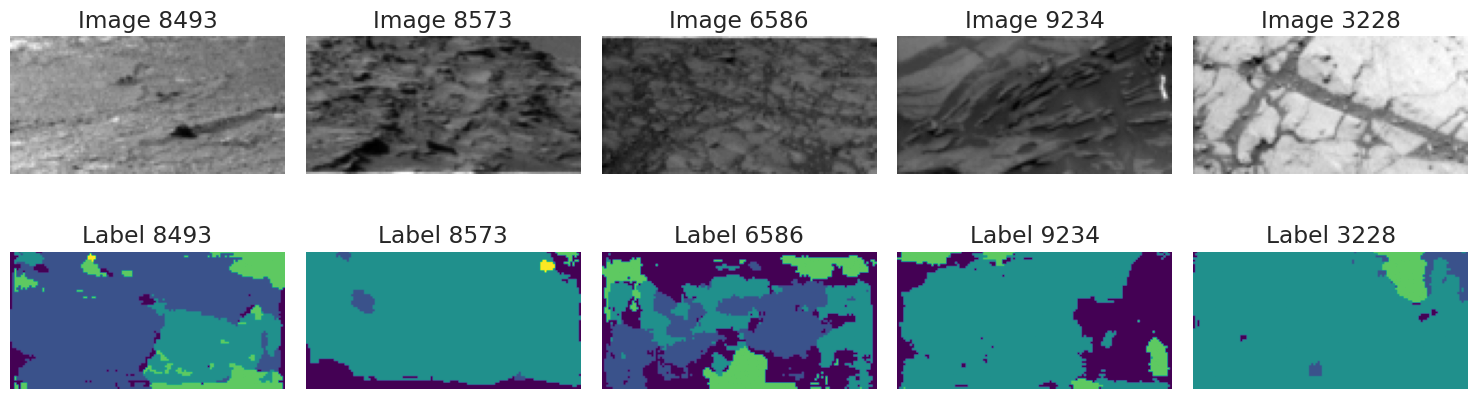

In [ ]:
# Plot 5 random images with labels
plot_random_images_with_labels(X_test, preds, num=5)


Distribuzione delle classi: {0: 17977825, 1: 24862621, 2: 23261352, 3: 15682154, 4: 316272}


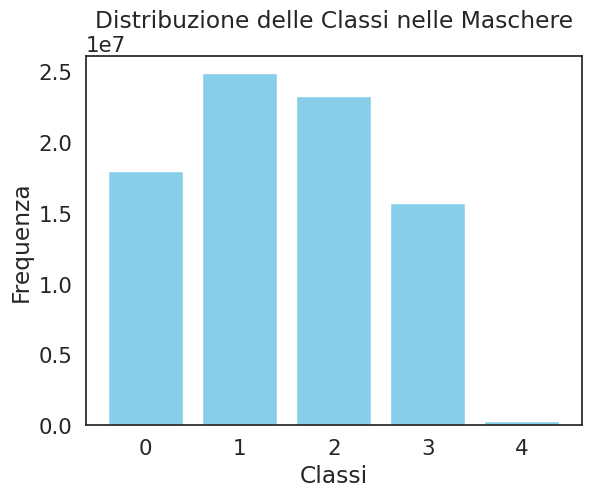

Numero di classi uniche nel dataset: 5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute class frequencies
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Visualization
print("Distribuzione delle classi:", class_distribution)

# Bar chart
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Classi')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle Classi nelle Maschere')
plt.xticks(list(class_distribution.keys()))
plt.show()

# Number of unique classes
print(f"Numero di classi uniche nel dataset: {len(class_distribution)}")


Above, we calculate and visualize the distribution of predicted classes, providing insights into class frequencies, and print the number of unique predicted classes to assess the model's output diversity

##🗂️preparing the submission

In [ ]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

print(f"Submission file saved to: {submission_filename}")
# from google.colab import files
# files.download(submission_filename)

Submission file saved to: submission_UNet_46.21.csv
